In [78]:
import os
from glob import glob
import pandas as pd
import json
import re
from pathlib import Path

%matplotlib inline

General data structure plan here is to create a dict for each paper, each key of which contains some sort of information about the paper. So, we have the standard metadata (DOI, date, title etc), and also possibly counts of certain regex matches, with keys for the regexes (or nicer names).

I'm not sure how to approach it when we need to store information about each individual match...

In [15]:
def get_article_metadata(folder_path):
    json_filename = str(folder_path / 'results.json')
    
    with open(json_filename) as f:
        j = json.load(f)
        
    selected_keys = ['doi', 'title', 'date', 'journal']
        
    filtered_dict = { k: j[k]['value'][0] for k in selected_keys }
    
    return filtered_dict

In [16]:
def count_regex_matches(pattern, fname, flags=0):
    with open(fname) as f:
        text = f.read()
        #print(text)
        
        count = len(re.findall(pattern, text, flags=flags))
        
    return count

In [17]:
def count_multiple_regexes(regexes, fname, flags=0):
    res = {}
    
    for item in regexes:
        try:
            regex, name = item
        except (TypeError, ValueError):
            regex = item
            name = item
        res[name] = count_regex_matches(regex, fname, flags=0)
        
    return res

In [41]:
def process_article(folder):
    # If not a valid CM folder then return
    if not (folder / 'results.json').exists() or not (folder / 'fulltext.xml').exists():
        return None
    
    # Get the metadata first
    results = get_article_metadata(folder)
    
    # Now we can actually do the processing!
    
    # As an example we will do a simple regex and count the results
    # This works for a single regex
    #results['Landsat'] = count_regex_matches('landsat', str(folder / 'fulltext.xml'))
    
    # To do multiple regexes nice and easily we can do the following
    
    # Set up a list of regexes (and optional nice names for them)
#     regexes = [('FLAASH'),
#                ('ATCOR'),
#                ('SMAC'),
#                ('6S', '6S'),
#                ('empirical line'),
#                ('\bELM\b')]


    regexes = [ ('python'),
                (' IDL ', 'IDL'),
                ('Java'),
                ('C\+\+', 'CPP'),
                ('Matlab')]
    
    regex_stats = count_multiple_regexes(regexes, str(folder / 'fulltext.xml'), flags=re.IGNORECASE)
    
    results.update(regex_stats)
    
    
    
    return results

In [42]:
p = Path()
#folders = p.glob('mdpi-rs-2014/**/')
folders = p.glob('mdpi-rs/**/**')

results = [process_article(folder) for folder in folders]

# Filter out the None's...there must be a better way to do this!
results = filter(None, results)
results = pd.DataFrame(list(results))
results.date = pd.to_datetime(results.date)

In [63]:
results['year'] = pd.DatetimeIndex(results.date).year

In [85]:
bool_res = results.copy()

In [86]:
bool_res[['IDL', 'CPP', 'Java', 'Matlab', 'python']] = bool_res[['IDL', 'CPP', 'Java', 'Matlab', 'python']] > 0

In [100]:
# peryear = results.groupby('year').apply(lambda x: (x > 0).sum())
peryear = bool_res.groupby('year').sum()
peryear = peryear[['IDL', 'CPP', 'Java', 'Matlab', 'python']]

In [102]:
yeartotal = peryear.sum(axis=1)

In [103]:
peryear['yeartotal'] = yeartotal

In [105]:
norm_by_prog_mention = peryear.div(peryear.yeartotal, axis='index')

In [112]:
papers_per_year = results.groupby('year').title.count()

In [113]:
papers_per_year

year
2009     82
2010    133
2011    139
2012    189
2013    338
2014    592
2015    774
Name: title, dtype: int64

In [115]:
norm_by_total_papers = peryear.div(papers_per_year, axis='index')

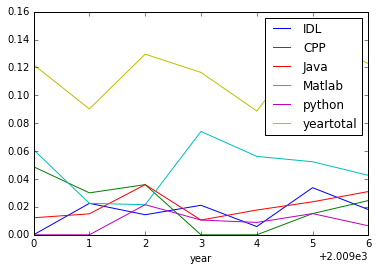

In [116]:
norm_by_total_papers.plot()

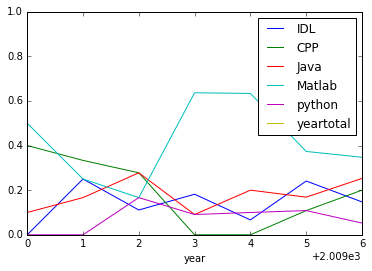

In [106]:
norm_by_prog_mention.plot()

In [34]:
(results > 0).sum()

 IDL         45
C\+\+        41
Java         54
Matlab      108
date       2247
doi        2247
journal    2247
python       22
title      2247
dtype: int64

In [118]:
results[results['IDL'] > 0]

,CPP,IDL,Java,Matlab,date,doi,journal,python,title,year
110,0,2,0,0,2014-12-12,10.3390/rs61212544,Remote Sensing,0,Hydrological Impacts of Urbanization of Two Ca...,2014
228,0,1,0,0,2014-12-30,10.3390/rs70100319,Remote Sensing,0,Annual Change Detection by ASTER TIR Data and ...,2014
238,0,1,0,0,2014-06-27,10.3390/rs6075976,Remote Sensing,0,Change Detection Algorithm for the Production ...,2014
258,0,1,0,0,2014-09-19,10.3390/rs6098878,Remote Sensing,0,Annual Detection of Forest Cover Loss Using Ti...,2014
295,0,1,1,0,2014-07-01,10.3390/rs6076183,Remote Sensing,1,Open Access Data in Polar and Cryospheric Remo...,2014
301,0,1,0,0,2014-08-19,10.3390/rs6087632,Remote Sensing,0,Development of a Novel Bidirectional Canopy Re...,2014
304,0,3,0,0,2014-12-05,10.3390/rs61212138,Remote Sensing,0,Application of In-Segment Multiple Sampling in...,2014
379,0,1,0,0,2014-08-29,10.3390/rs6098238,Remote Sensing,0,Noise Reduction and Gap Filling of fAPAR Time ...,2014
418,0,2,0,0,2014-01-29,10.3390/rs6021234,Remote Sensing,0,Detection of Coal Fire Dynamics and Propagatio...,2014
428,0,3,0,0,2014-07-29,10.3390/rs6087005,Remote Sensing,0,Mineral Classification of Land Surface Using M...,2014
